<a href="https://colab.research.google.com/github/1000century/likelion_proj2/blob/main/code/train/v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install datasets -qq
! pip install bert_score -qq
! pip install rouge-score -qq
! pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [ ]:
import gc

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

# 데이터셋을 로컬이나 HuggingFace Hub에 저장하기
# dataset.save_to_disk("path/to/local/directory")  # 로컬에 저장
# dataset.push_to_hub("username/dataset-name")     # HuggingFace Hub에 업로드

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import numpy as np

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset['train'][0]

{'version': '1.0',
 'category': 'TL',
 'job_field': '07.ProductionManufacturing',
 'gender': 'Female',
 'experience': 'Experienced',
 'dataSet_info_date': '20230116',
 'dataSet_info_occupation': 'MM',
 'dataSet_info_channel': 'MOCK',
 'dataSet_info_place': 'ONLINE',
 'dataSet_info_gender': 'FEMALE',
 'dataSet_info_ageRange': '45-54',
 'dataSet_info_experience': 'EXPERIENCED',
 'dataSet_question_raw_text': '지원자님께서는 지금까지 여러 가지 대외 활동들을 경험해 보셨을 텐데요 지원자님이 경험했던 대외 활동들 중에서 어떤 것들을 배웠고 또 어떤 자세로 임했는지 답변해 주시기 바랍니다',
 'dataSet_question_raw_wordCount': 24,
 'dataSet_question_emotion': [],
 'dataSet_question_intent': [],
 'dataSet_answer_raw_text': '대외 활동을 하면서 회사에서는 배울 수 없는 다른 것들을 좀 많이 배웠는데요. 제가 지금 기억에 남는 대외 활동은 연말에 어 어려운 분들을 돕기 위한 자선 어 바자회를 진행했던 것입니다. 회사에서 모아 모아 놓은 물건을 가지고 어 판매를 했었는데요. 어 그때 좀 성향들이 보였던 것 같아요. 어 생각보다 지위도 있고 그것도 많이 받으시는 분들은 좀 인색한 경우도 있었고 오히려 뭐 저희가 쫌 어려운 상황이다 형편을 생각했던 경비 아저씨 께서 큰 금액을 조금 흔쾌히 내놓으셨던 그런 경험이 있습니다. 어 그래서 어떤 사람을 돕는 마음에는 지위나 경제적 부와는 전혀 상관이 없는 어 그런 것을 좀 많이 느껴서 느낀 바도 많고 또 어떤 사람의

In [ ]:
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs =[
        f"</s> 질문: {q} 답변: {a} </s>"
        for q,a in zip(examples["dataSet_answer_summary_text"],examples["dataSet_answer_raw_text"])
    ]
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation= True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = inputs['input_ids'].clone()
    labels[labels==tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return inputs


train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

val_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
print(len(train_dataset))
# # 코드 잘 돌아가는지 확인 위해 train_dataset 임의로 매우 적은 개수로 샘플링
# from torch.utils.data import Subset
# train_dataset = Subset(train_dataset, indices=range(40))
# val_dataset = Subset(val_dataset, indices=range(80))
print(len(train_dataset))
print(len(val_dataset))

68074
68074
8026


# Model

In [ ]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
import psutil
import os

def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1e6} MB")


In [ ]:
from transformers import Trainer
import evaluate

In [ ]:
import evaluate
import numpy as np
import torch
from rouge_score import rouge_scorer
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
bleu = evaluate.load('bleu')

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Predictions 튜플 처리
    print("\n", '='*50,"\nPredictions type:", type(predictions))
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Predictions와 Labels를 numpy 배열로 변환
    if isinstance(predictions, torch.Tensor):
        print("Converting Predictions to numpy...")
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        print("Converting Labels to numpy...")
        labels = labels.cpu().numpy()

    # Decode predictions and labels
    print("Decoding predictions and labels...")
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=False)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)

    # Post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    print("Decoded Predictions Sample:\n", decoded_preds[:3])
    print("Decoded Labels Sample:\n", decoded_labels[:3])

    # Calculate ROUGE metrics using rouge-score
    print("Calculating ROUGE...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:  # 둘 다 비어있지 않은 경우만 계산
            scores = scorer.score(label, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    print("\nROUGE scores details:")
    print(f"Number of valid pairs: {len(rouge_scores['rouge1'])}")
    if rouge_scores['rouge1']:
        print(f"Sample ROUGE-1 scores: {rouge_scores['rouge1'][:5]}")

    rouge_result = {
        'rouge1': np.mean(rouge_scores['rouge1']) * 100 if rouge_scores['rouge1'] else 0,
        'rouge2': np.mean(rouge_scores['rouge2']) * 100 if rouge_scores['rouge2'] else 0,
        'rougeL': np.mean(rouge_scores['rougeL']) * 100 if rouge_scores['rougeL'] else 0
    }

    # Calculate other metrics
    print("Calculating METEOR...")
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    print("METEOR result:", meteor_result)

    print("Calculating BERTScore...")
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ko", device='cuda' if torch.cuda.is_available() else 'cpu')
    print("BERTScore finished")

    print("Calculating BLEU...")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    print("BLEU result:", bleu_result)

    # Combine results
    result = {
        **rouge_result,
        "meteor": round(meteor_result["meteor"] * 100, 4),
        "bertscore_f1": round(np.mean(bertscore_result["f1"]) * 100, 4),
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

    print("Calculating generated length...")
    result['gen_len'] = np.mean([len(pred.split()) for pred in decoded_preds])
    print("Final Metrics:", result)

    return result

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
from transformers import Trainer, TrainingArguments

# Training arguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델이 저장될 경로
    evaluation_strategy="epoch",    # 매 에포크마다 평가
    save_strategy="epoch",          # 매 에포크마다 저장
    learning_rate=5e-5,             # 기본 학습률
    per_device_train_batch_size=16,  # 각 디바이스에서의 배치 사이즈
    per_device_eval_batch_size=32,   # 평가 시의 배치 사이즈
    eval_accumulation_steps=8,      # 평가 시 gradient accumulation steps
    num_train_epochs=6,             # 에포크 수
    weight_decay=0.01,              # 가중치 감쇠
    save_total_limit=2,             # 저장할 체크포인트 개수 제한
    logging_dir='./logs',           # 로깅 파일 저장 위치
    logging_steps=500,              # 로깅 빈도
    load_best_model_at_end=True,    # 가장 좋은 모델을 끝에서 로드
    eval_steps=1000,                # 평가 빈도
    fp16=True,                      # Mixed Precision (FP16) 사용
    dataloader_num_workers=4,       # DataLoader에서 사용할 워커 수
    deepspeed=None,                 # DeepSpeed는 사용하지 않음
    report_to="none",               # 로깅 서비스 (TensorBoard 등 사용하지 않음)
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)

# DataLoader 확인 및 메모리 상태 출력
print(f"Total train batches: {len(trainer.get_train_dataloader())}")
print(f"Total eval batches: {len(trainer.get_eval_dataloader())}")
print(f"Batch size train: {training_args.per_device_train_batch_size}")
print(f"Batch size eval: {training_args.per_device_eval_batch_size}")
print(f"Eval accumulation steps: {training_args.eval_accumulation_steps}")

Total train batches: 2128
Total eval batches: 126
Batch size train: 16
Batch size eval: 32
Eval accumulation steps: 8


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
import warnings
import os

# fork 관련 경고 제거
warnings.filterwarnings('ignore', message="os.fork()")

# tokenizer 경고 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# autocast 경고 제거
warnings.filterwarnings('ignore', message="`torch.cuda.amp.autocast")

# gather 경고 제거
warnings.filterwarnings('ignore', message="Was asked to gather along dimension 0")

In [ ]:
# 학습 시작
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,2.958400,2.916679,5.590246,0.142939,5.590246,20.691100,71.543900,7.389000,174.015824
2,2.806500,2.862944,5.605773,0.128483,5.605773,21.203400,72.134500,6.934300,157.191378
3,2.707300,2.837547,5.647275,0.162107,5.647275,21.381800,72.040200,7.282200,162.670321
4,2.620600,2.821647,5.556613,0.122879,5.556613,21.471100,72.152400,6.924100,154.507227
5,2.552500,2.816025,5.592240,0.143442,5.592240,21.604100,72.348000,6.969800,152.315848
6,2.497200,2.817630,5.598141,0.133037,5.598141,21.645500,72.402900,6.877200,150.674807



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['질문: 저 인재 하면서 것은 가장반사기 때문에 저 지역에서 업무를 수행 것은 대해서는감이 없습니다. 타 타 타사를 하게 된서 지역에서의도 하게 된 것은 대한 전혀 거부하지 않 있습니다. 타 지역에서 업무를 하게 다른 점이 있는 것들이 많 것이라고 답변: 타 타 활동을 게 하는 싶 게 다 다반사이 때문에 타 타 지역에서 업무를 수행하는 것에 자체에 거부 거부감이 없습니다. 어 타 타 지금덩어리가 넓 않 때문에 타구권에 아니 하고 또 가야도 간에 문제가 없을습니다. 그리고 제가 타 태어나 컸다 하고 또 타는 다른 타 타하게 뭐 일을 있는장을 가거나 하는 근무를할에 인 타 그런 없요. 그리고 타 입사를 하게 돼서 타 지역으로 가서 근무를 하게 되는 것에 대해서는 크게 염려하지 않고 있습니다. 타 타 지역에서 근무를 근무를 하게 배울 수 있는 점도 많을 거 있습니다.요. 타 타 타덩어리가 크기 하고 타사는더라도 곳에서 있고습니다.아요. 그래서 타 된면은 타 입지 못한 곳에서 가서보고 것도  것 같습니다. </s>  타 뭐 타 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 뭐 타 뭐 타 뭐 타 뭐 타 뭐 뭐 타 타 타 타 타 타 타 뭐 뭐 타 타 타 뭐 타 타 타 타 타 타 타 뭐 타 타 뭐 타 타 뭐', '질문: 저업 하면서 가장 어려웠던 점은 의견 의견을이나 잘 것이었습니다. 협을 설득하는 나누  것이 가장 그 가장 않으면 때 다른 세워 이야기를자에게원 일을 되는 일을 나눠 캐내는 되는 협 될져서 일을업을 잘될 수 있었습니다. 답변: 협 협업을 하면서 가장 어려웠던 점은 자신의 조직만 생각하는 것이었습니다. 설득업을 하면서 그의가 굉 있고 그도 같은비는 다지기 되는에도 불구하고 자신의 사업나 어떤 단체에서는 경우에는들은 대표 조직 다 있는 사람들이 자신의 조직 이익을

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore finished
Calculating BLEU...
BLEU result: {'bleu': 0.0738897456373464, 'precisions': [0.3829522890462716, 0.19397822616871727, 0.1190116786110764, 0.07987585723715217], 'brevity_penalty': 0.453271569745499, 'length_ratio': 0.5582650511230862, 'translation_length': 1528475, 'reference_length': 2737902}
Calculating generated length...
Final Metrics: {'rouge1': 5.590245673025172, 'rouge2': 0.14293893386994228, 'rougeL': 5.590245673025172, 'meteor': 20.6911, 'bertscore_f1': 71.5439, 'bleu': 7.389, 'gen_len': 174.01582357338648}

Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['질문: 저 인재 하면서 데 가장들사기 때문에 영어 지역 업무를 수행 것은 대해서는감이 없습니다. 타 타 가진사를 하게 된도 지역 업무를 일을 하게 된 경우 대해 전혀 거부하지 않 있습니다. 타 지역 업무를 하게 많은 수 있는 점이 많 것이라고 답변: 네 타 활동을 게 하는 싶 게 다 다반사이 때문에 타 타 지역에서 업무를 수행하는 것에 자체에 거부 거부감이 없습니다. 어 타 타 글로벌덩어리가 크고 않기 때문에 타구권 있고 하고 또 출도 간에 상관 없을습니다. 다만 제가 제가 초등학교 컸다 하고 또 뭐는 저 타 뭐하게 뭐 일을 있는장을 간거나 아니면 근무를하에 인 뭐 문제는 없 또 그리고 타 입사를 하게 돼서 타 지역으로 가서 근무를 하

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=12768, training_loss=2.706476775625893, metrics={'train_runtime': 22328.9363, 'train_samples_per_second': 18.292, 'train_steps_per_second': 0.572, 'total_flos': 5.3361581359104e+16, 'train_loss': 2.706476775625893, 'epoch': 6.0})

In [ ]:
import os
import shutil

# 모델 가중치와 설정 저장
trainer.save_model("./results/best_model")

# 학습 상태 저장
trainer.save_state()

In [ ]:
import torch

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")


GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 4028.00 MB
  사용 중인 메모리: 2102.13 MB
  사용 가능 메모리: 1925.87 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 32.00 MB
  사용 중인 메모리: 16.25 MB
  사용 가능 메모리: 15.75 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="본인의 강점이 무엇이라고 생각하시나요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,            # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Text:
본인의 강점이 무엇이라고 생각하시나요 라는 질문에 대한 저의 답변을 말씀드리겠습니다. 저는 다른 지원자들에 비해 지원자님만의 차별성 장점을 어필한다면 어떤 것이 있을까요 라고 질문해 주셨습니다. 이 면접에서 최종 탈락하게 된다면 어떤 점이 부족해서 탈락했다고 생각하시는지 말씀해 주시길 바랍니다. 답변: 네 제가 이 직무에 지원한 이유는 어 다른 분들에 비해서 제가 가진 차별성이나 장점이 무엇인지 여쭤보셨는데요. 어 일단은 저 같은 경우에는 어 제가 가지고 있는 장점이나 차별성이 어 뭐라고 생각을 하냐고 물어보신다면 어 일단 다른 사람들보다는 제가 다른 사람보다 좀 더 차별성을 가지고 있다고 생각을 하기 때문에 어 그런 점에 있어서 어 좀 차별성과 장점이 있다고 생각해서 지원하게 되었습니다. 어 그래서 다른 사람들이 저를 봤을 때 저에 대해서 좀 어색하지 않고 좀 잘 챙겨준다고 생각을 하고 어 저도 그런 점이 있기 때문에 그런 점들을 잘 어필을 할 수 있을 것 같다고 생각을 해서 어 이렇게 지원을 하게 된 것 같구요. 그리고 어 또 저만의 장점이라고 한다면 어 어떤 부분이 부족하냐 라고 질문을 해 주신 것 같은데요. 음 다른 사람들은 저에게 좀 부족한 점이 많다고 생각하는데 저


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="저희 회사가 당신을 뽑아야 하는 이유를 설명하세요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,             # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

Generated Text:
저희 회사가 당신을 뽑아야 하는 이유를 설명하세요 라고 질문해 주셨습니다. 저는 제가 지원한 직무가 아닌 다른 부서에 배치되게 된다면 굉장히 당황스러울 것 같습니다. 하지만 다른 부서에서 일을 하다 보면 제가 잘 할 수 있는 일이 있을 것이라고 생각하기 때문에 최선을 다해서 열심히 하겠습니다. 답변: 만약 제가 하고 싶은 직무 말고 다른 직무를 맡게 되신다면 어떻게 하시겠습니까 그래도 괜찮으신가요. 여기에 대한 저의 답변을 말씀드리겠습니다. 제가 이 직무에 지원하게 된 계기는 제가 어렸을 적부터 꿈꿔왔던 일이기 때문입니다. 대학 시절 아르바이트를 포함하여 인턴 생활 등 다양한 분야에서 일한 경험이 있습니다. 이러한 경험을 바탕으로 잘 해 나갈 수 있을 거라 생각되어 지원했습니다. 또한 제가 미처 깨닫지 못한 저만의 강점을 발견해 낼 수도 있을 것 같아 지원하였습니다. 이렇게 지원하시는 이유를 말씀해 주시면 감사하겠습니다 라고 질문하신 후 저를 뽑아주셨으면 좋겠다는 말씀을 드리고 싶습니다. 감사합니다. 저에게 맡겨주신 일이 저와 잘 맞지 않는다면 어떻게 하겠냐고 물어보셨는데요. 저 같은 경우에는 저보다 더 잘 맞을 거라고 생각하실 수도 있으실 텐데요. 하지만


In [ ]:
torch.cache()

AttributeError: module 'torch' has no attribute 'cache'

In [2]:
import pandas as pd

def text_to_df(text):
    # 문자열을 StringIO로 변환하여 read_csv로 읽기
    from io import StringIO
    df = pd.read_csv(StringIO(text), sep='\t', index_col='Epoch')
    return df

# 사용 예시
text = """Epoch	Training Loss	Validation Loss	Rouge1	Rouge2	Rougel	Meteor	Bertscore F1	Bleu	Gen Len
1	2.958400	2.916679	5.590246	0.142939	5.590246	20.691100	71.543900	7.389000	174.015824
2	2.806500	2.862944	5.605773	0.128483	5.605773	21.203400	72.134500	6.934300	157.191378
3	2.707300	2.837547	5.647275	0.162107	5.647275	21.381800	72.040200	7.282200	162.670321
4	2.620600	2.821647	5.556613	0.122879	5.556613	21.471100	72.152400	6.924100	154.507227
5	2.552500	2.816025	5.592240	0.143442	5.592240	21.604100	72.348000	6.969800	152.315848
6	2.497200	2.817630	5.598141	0.133037	5.598141	21.645500	72.402900	6.877200	150.674807"""

history_df = text_to_df(text)
print(history_df)

       Training Loss  Validation Loss    Rouge1    Rouge2    Rougel   Meteor  \
Epoch                                                                          
1             2.9584         2.916679  5.590246  0.142939  5.590246  20.6911   
2             2.8065         2.862944  5.605773  0.128483  5.605773  21.2034   
3             2.7073         2.837547  5.647275  0.162107  5.647275  21.3818   
4             2.6206         2.821647  5.556613  0.122879  5.556613  21.4711   
5             2.5525         2.816025  5.592240  0.143442  5.592240  21.6041   
6             2.4972         2.817630  5.598141  0.133037  5.598141  21.6455   

       Bertscore F1    Bleu     Gen Len  
Epoch                                    
1           71.5439  7.3890  174.015824  
2           72.1345  6.9343  157.191378  
3           72.0402  7.2822  162.670321  
4           72.1524  6.9241  154.507227  
5           72.3480  6.9698  152.315848  
6           72.4029  6.8772  150.674807  


In [ ]:
# # 기존 trainer에서 학습 로그 가져오기
# training_logs = trainer.state.log_history

# # DataFrame으로 변환하여 보기 좋게 표시
# import pandas as pd
# history_df = pd.DataFrame(training_logs).reset_index()
# print("\nTraining history:")
# display(history_df)

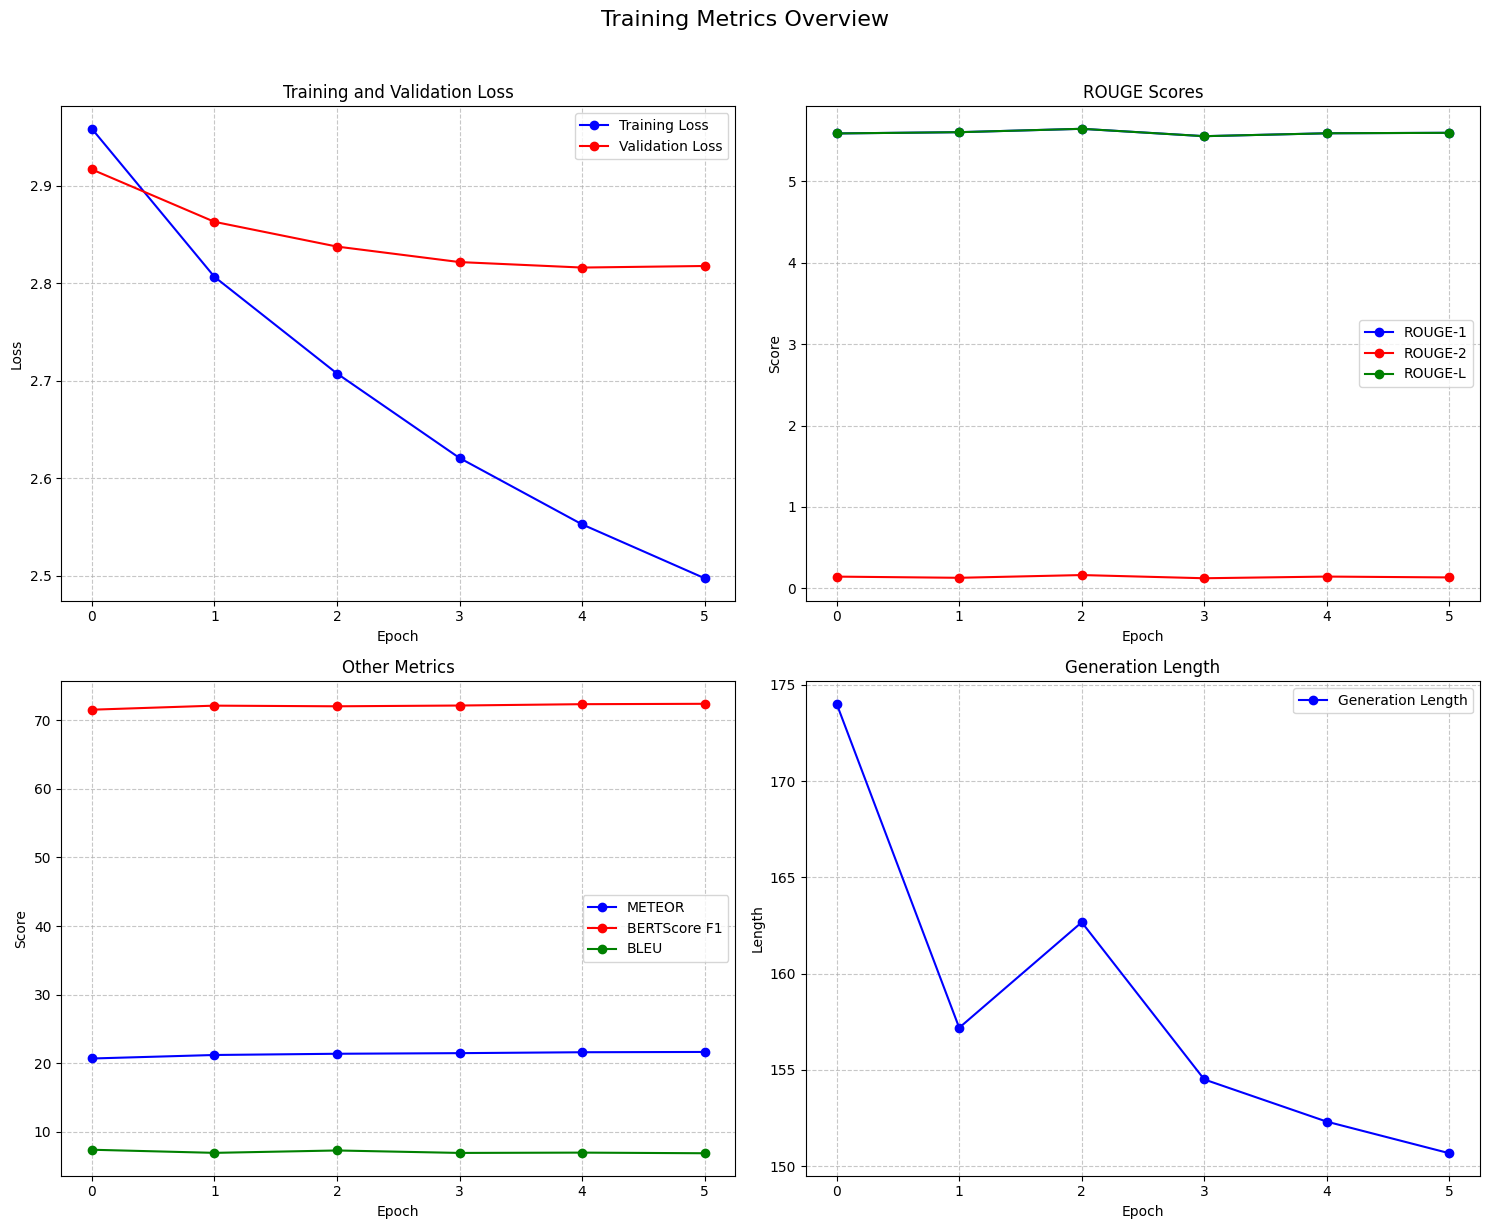


Final Metrics:
Train Loss: 2.4972
Validation Loss: 2.8176
ROUGE-1: 5.5981
ROUGE-2: 0.1330
ROUGE-L: 5.5981
METEOR: 21.6455
BERTScore: 72.4029
BLEU: 6.8772
Generation Length: 150.6748


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# nan 값을 제외하고 데이터 추출
train_loss = history_df['Training Loss'].dropna().values
eval_loss = history_df['Validation Loss'].dropna().values
rouge1 = history_df['Rouge1'].dropna().values
rouge2 = history_df['Rouge2'].dropna().values
rougeL = history_df['Rougel'].dropna().values
meteor = history_df['Meteor'].dropna().values
bertscore = history_df['Bertscore F1'].dropna().values
bleu = history_df['Bleu'].dropna().values
gen_len = history_df['Gen Len'].dropna().values

# 실제 데이터 개수에 맞춰 epochs 배열 생성
epochs = np.arange(len(eval_loss))

# 그래프 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Overview', fontsize=16, y=1.02)

# Loss plot
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores over time
ax2.plot(epochs, rouge1, 'b-', label='ROUGE-1', marker='o')
ax2.plot(epochs, rouge2, 'r-', label='ROUGE-2', marker='o')
ax2.plot(epochs, rougeL, 'g-', label='ROUGE-L', marker='o')
ax2.set_title('ROUGE Scores')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Other metrics
ax3.plot(epochs, meteor, 'b-', label='METEOR', marker='o')
ax3.plot(epochs, bertscore, 'r-', label='BERTScore F1', marker='o')
ax3.plot(epochs, bleu, 'g-', label='BLEU', marker='o')
ax3.set_title('Other Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Generation length
ax4.plot(epochs, gen_len, 'b-', label='Generation Length', marker='o')
ax4.set_title('Generation Length')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Length')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# 그래프 저장
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과값들 출력
print("\nFinal Metrics:")
print(f"Train Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {eval_loss[-1]:.4f}")
print(f"ROUGE-1: {rouge1[-1]:.4f}")
print(f"ROUGE-2: {rouge2[-1]:.4f}")
print(f"ROUGE-L: {rougeL[-1]:.4f}")
print(f"METEOR: {meteor[-1]:.4f}")
print(f"BERTScore: {bertscore[-1]:.4f}")
print(f"BLEU: {bleu[-1]:.4f}")
print(f"Generation Length: {gen_len[-1]:.4f}")